In [1]:
import cv2
import glob
import pandas as pd
import os
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## Data

In [3]:
pd_labels = pd.read_csv('C:/Users/spradha5/NeuralC2/train_files.csv')

In [4]:
pd_labels = pd_labels.sort_values(by=['file_name'])

In [5]:
#One hot Encode labels
training_Y = keras.utils.to_categorical(pd_labels['annotation'], 5)

In [6]:
training_Y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [7]:
training_Y.shape

(896, 5)

## Model

In [8]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten

## Transfer Learning Model

In [9]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(480, 640, 3))

In [10]:
output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False 

In [11]:
train_features_vgg= np.load('C:/Users/spradha5/NeuralC2/Approach1/train_features_vgg.npy')
unlabeled_features_vgg= np.load('C:/Users/spradha5/NeuralC2/Approach1/unlabeled_features_vgg.npy')

In [12]:
print('Train Bottleneck Features:', train_features_vgg.shape, 
      'Unlabelled Bottleneck Features:', unlabeled_features_vgg.shape)

Train Bottleneck Features: (896, 153600) Unlabelled Bottleneck Features: (750, 153600)


In [13]:
#hyperparameters

#original values
#neurons = 512
#drop_prob = 0.3
#learning_rate = 0.0001
#max_runs = 20
#batchsize = 64
#num_epochs = 20


neurons1 = 512
neurons2 = 512
drop_prob = 0.2
learning_rate = 0.0001
max_runs = 10
batchsize = 64
num_epochs = 6

In [14]:
#changes from replica model:
#loss = categorical instead of binary crossentropy
#optimizer = adam instead of RMSprop

In [15]:
input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(neurons1, activation='relu', input_dim=input_shape))
model.add(Dropout(drop_prob))
model.add(Dense(neurons2, activation='relu'))
model.add(Dropout(drop_prob))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               78643712  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 78,908,933
Trainable params: 78,908,933
Non-trainable params: 0
_________________________________________________________________


In [16]:
itr = 0
semisuper_history = []

In [17]:
while(itr<max_runs):
    trainX = train_features_vgg[0:int(0.75*len(train_features_vgg))]
    valX = train_features_vgg[int(0.75*len(train_features_vgg)):]
    
    trainY = training_Y[0:int(0.75*len(training_Y))]
    valY = training_Y[int(0.75*len(training_Y)):]
    
    history = model.fit(x=trainX, y=trainY,
                    validation_data=(valX, valY),
                    batch_size=batchsize,
                    epochs=num_epochs,
                    verbose=1)
    
    temp_unlabeled_features_vgg = []
    print(len(unlabeled_features_vgg))
    for ulb in unlabeled_features_vgg:
        temp = model.predict(np.array([ulb]))
        
        if(np.any(temp > 0.6)):
            train_features_vgg = np.vstack((train_features_vgg,ulb))
            training_Y = np.vstack((training_Y,keras.utils.to_categorical(np.argmax(temp), 5)))
        else:
            temp_unlabeled_features_vgg.append(ulb)
    print("Before",len(unlabeled_features_vgg))
    print("After",len(temp_unlabeled_features_vgg))
    if(len(temp_unlabeled_features_vgg) == 0):
        break
    semisuper_history.append(history.history)
    if(len(temp_unlabeled_features_vgg) == len(unlabeled_features_vgg)):
        break
        
    unlabeled_features_vgg = temp_unlabeled_features_vgg
    itr=itr+1
    

Train on 672 samples, validate on 224 samples
Epoch 1/6
672/672 [==============================] - 5s 7ms/sample - loss: 2.4195 - accuracy: 0.3735 - val_loss: 1.2372 - val_accuracy: 0.4911
Epoch 2/6
672/672 [==============================] - 2s 3ms/sample - loss: 1.1217 - accuracy: 0.5878 - val_loss: 0.7566 - val_accuracy: 0.6875
Epoch 3/6
672/672 [==============================] - 2s 3ms/sample - loss: 0.6649 - accuracy: 0.7515 - val_loss: 0.6438 - val_accuracy: 0.7545
Epoch 4/6
672/672 [==============================] - 2s 3ms/sample - loss: 0.5184 - accuracy: 0.8065 - val_loss: 0.5868 - val_accuracy: 0.7455
Epoch 5/6
672/672 [==============================] - 2s 3ms/sample - loss: 0.4138 - accuracy: 0.8631 - val_loss: 0.4678 - val_accuracy: 0.8036
Epoch 6/6
672/672 [==============================] - 2s 3ms/sample - loss: 0.2913 - accuracy: 0.8988 - val_loss: 0.4662 - val_accuracy: 0.8125
750
Before 750
After 194
Train on 1089 samples, validate on 363 samples
Epoch 1/6
1089/1089 [===

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy for selected model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.savefig('FinalAccuracy.png')
plt.show()

<Figure size 640x480 with 1 Axes>

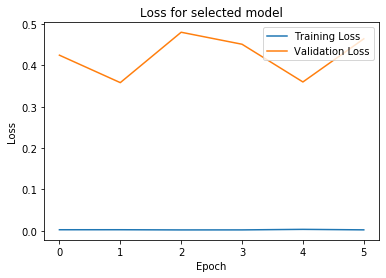

In [19]:
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss for selected model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig('FinalLoss.png')
plt.show()

In [20]:
model.save('final_model_approach6.h5')